## LOAD PYTHON LIBRARIES

In [297]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image

## READ CSV, clean table, save to reduced/faster pickle xz format

In [96]:
data = pd.read_csv('datalink_0.csv')

data = data.rename(columns={'particle':'track'}) # if they are linked, they're tracks, not particles

data = data[['x', 'y', 'frame', 'track']] # remove unnecessary columns, to avoid RAM overhead

# save to compressed pickle native format instead. saves disk space in TESLA 
# pickle also has faster read/write rate. 
# protocol=5 option is optimal for large data frames, see 'https://docs.python.org/3/library/pickle.html'
data.to_pickle('./block0.pkl.xz', compression='xz') 


comparison of file size in different storage formats:
[<img src="./sizes.png" width="600"/>](./sizes.png)

## READ PICKLE

In [357]:
data = pd.read_pickle('block0.pkl')

nt = np.max(data.frame.values) # number of frames (assumming there is at least one complete track)
print('no. of frames in block: ', nt)
print('\ndata frame head\n')
data.head(10)

no. of frames in block:  7693

data frame head



,x,y,frame,track
0,383.002264,15.451185,1,0
1,607.438241,498.281619,1,1
2,520.106934,498.181264,1,2
3,492.810030,497.767482,1,3
4,456.952349,498.213531,1,4
5,442.900097,497.621980,1,5
6,383.047335,497.871839,1,6
7,357.097541,498.488254,1,7
8,339.614004,498.295217,1,8
9,65.714670,499.153998,1,9


## __tracks_len:__ get list of tracks ids; and no. of tracks

INPUT: data frame 'df' with tracks

OUTPUT: 
* lengths: array with lenghts of all tracks
* track_list: array with tracks IDs 
* ntracks: no. of tracks

## __reindex_tracks:__ resets tracks IDs in logical order: 1,2,3...., ntracks

INPUT: 

* df: data frame with tracks
* arr: array with tracks list

OUTPUT: data frame with 'track' column modified

In [176]:
def tracks_len(df):
    track_list = np.unique(df.track.values) # list of current track_listk IDs
    lengths = np.array( [len(df[df.track==i]) for i in track_list] ) # length of each track
    return track_list, lengths, ntracks

def reindex_tracks(df, arr):
    # replace tracks IDs with logical order count
    ntracks = len(arr)
    for i in range(ntracks):
        df.loc[df.track == arr[i],'track'] = i
    return df

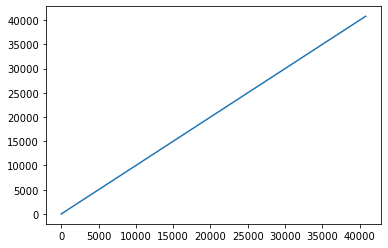

In [177]:
# OBTAIN tracks list, total number and length of each track
track_list, lengths, ntracks = tracks_len(data)
plt.plot(track_list); # reindex track list is only necessary if this plot is not a straight line

In [162]:
def tracks_len(df):
    track_list = np.unique(df.track.values) # list of current track_listk IDs
    lengths = [len(df[df.track==i]) for i in track_list] # length of each track
    return lengths, track_list, ntracks

In [165]:
track_list, lengths, ntracks= tracks_len(data)

## __split_short:__ SPLITS data frame into 3: one with short tracks and one with long enough tracks, and one with tracks with intermediate length (if limits are unequal)

INPUT
* df: data frame of tracks to split
* larr: list of lengths of each track
* ili: first threshold length; tracks longer than 'il' go to the long or intermediate tracks sub data frame
* ilf: second threshold; maximum length for the intermediate tracks

OUTPUT
* df_long, df_short: long, middle, and short tracks sub data frames, respectively

In [183]:
def split_short(df, larr, ili, ilf):
    # where: selects track indexes of length array whose values are < or >= than a value
    # isin: selects indexes of the table that fulfill condition in the line above,
    # in this case, track indexes for which value in length array is < or >= il
    # reset_index: resets data frame row index; drop=True means discard old row index
    df_short = df[df.track.isin(np.where(larr < ili)[0])].reset_index(drop=True)
    if ili != ilf:
        df_middle = df[ df.track.isin(np.where((larr >= ili) & (larr < ilf))[0]) ]
    else:
        df_middle = []
    df_long = df[df.track.isin(np.where(larr >= ilf)[0])].reset_index(drop=True)
    return df_long, df_middle, df_short

In [187]:
data_long, data_middle, data_short = split_short(data, lengths, 700, 800)

## Localize/characterize short tracks

## __n2d_plot:__ 2D tracks density

INPUT
* idf: figure index (just formal, needed by python)
* df: data frame with tracks
* nbins: no. of bins of histogram
* fs: figure size
* tit: figure title

OUTPUT

H: 2D tracks density field

In [353]:
def n2d_plot(idf, df,nbins,fs,tit):
    H, x_edges, y_edges= np.histogram2d(df.x.values, df.y.values, bins=nbins)
    H = H.T
    plt.figure(idf,figsize=(fs,fs))
    ax = plt.subplot()
    ax.set_title(tit)
    ax.imshow(H, cmap='nipy_spectral', origin='lower', interpolation='gaussian', 
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]);
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%",pad=0.1)
    plt.colorbar(im, cax=cax)
    return H

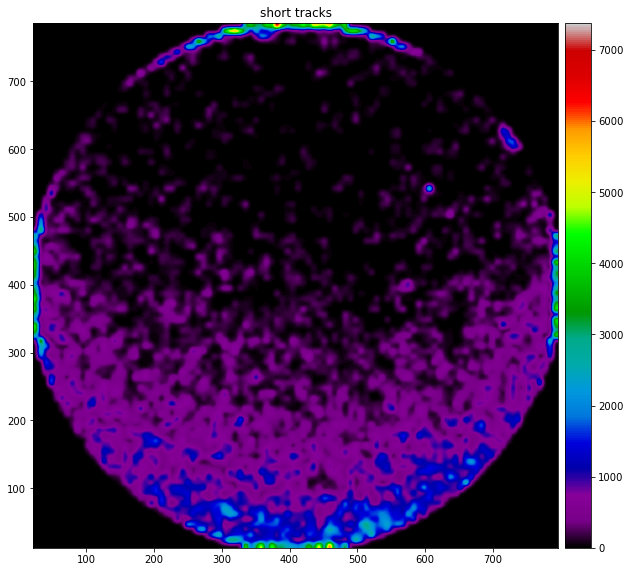

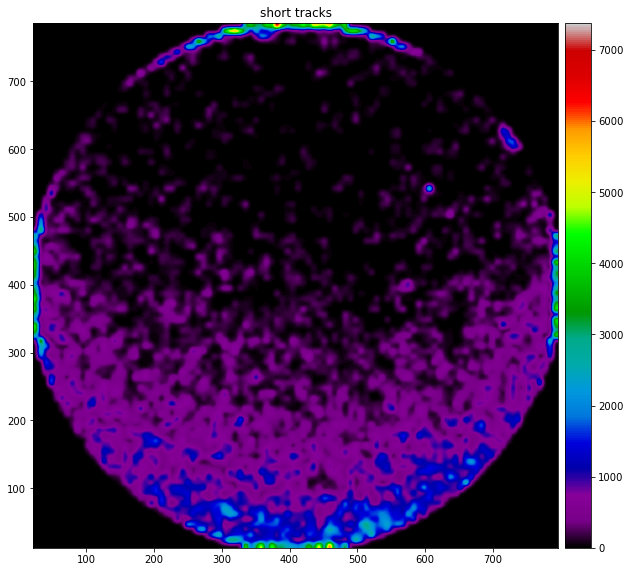

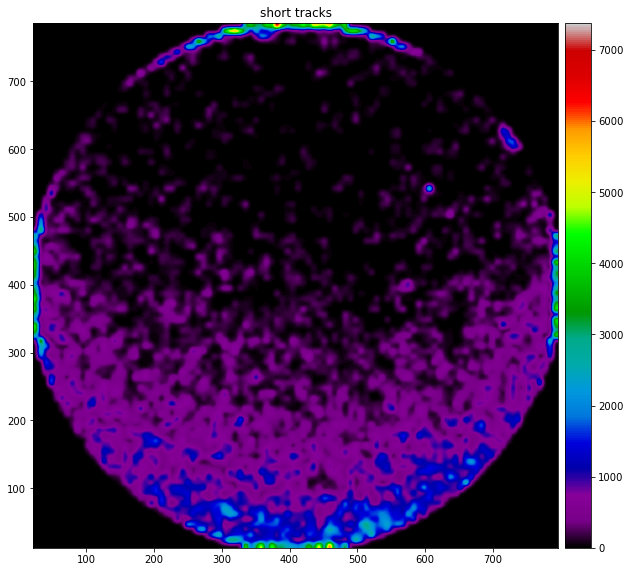

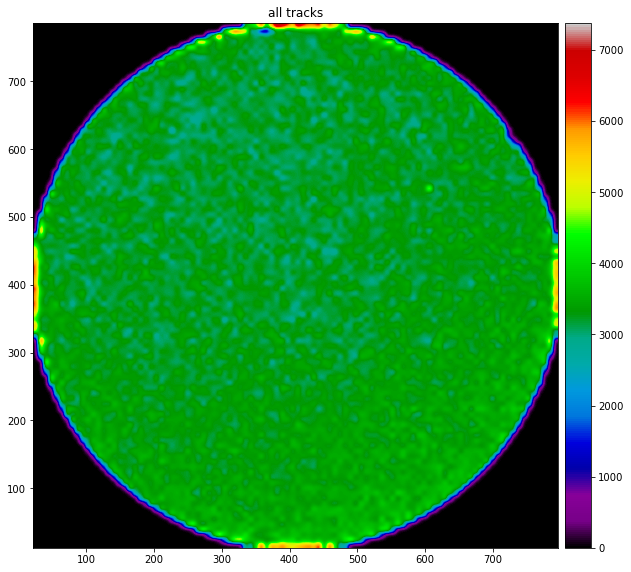

In [352]:
# short tracks particle density
H_short = n2d_plot(1, data_short, 100, 10, "short tracks")
# middle tracks 
H_middle = n2d_plot(2, data_short, 100, 10, "short tracks")
# long tracks
H_long = n2d_plot(3, data_short, 100, 10, "short tracks")
# all tracks particle density
H = n2d_plot(4, data, 100, 10, "all tracks")

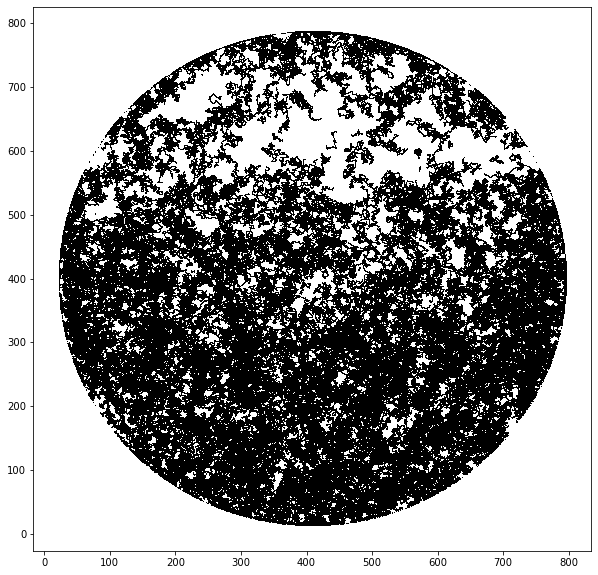

In [46]:
# another type of (simpler) representation
plt.figure(figsize=(10,10))
plt.plot(data_short.x.values, data_short.y.values,',',c='k')